<a href="https://colab.research.google.com/github/tkasod2/TIL/blob/main/prj_analysis/Ecommerce_pandas_with_sqlite_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA 원본 출처 : https://www.kaggle.com/mkechinov/ecommerce-events-history-in-electronics-store/version/1

1% 데이터만 추출하고, 저장해둔 데이터를 사용한다.
``` python
df.sample(frac = 0.01).reset_index(drop = True)
```

In [1]:
!gdown --id 1BSHIKQ7rFw5BpTq5nw1UZfjPK_7Mpnbi
!mv _sqlite3.cpython-37m-x86_64-linux-gnu.so /usr/lib/python3.7/lib-dynload/
# https://stackoverflow.com/questions/59427642/upgrading-sqlite-in-colab/59429952#59429952
# restart

Downloading...
From: https://drive.google.com/uc?id=1BSHIKQ7rFw5BpTq5nw1UZfjPK_7Mpnbi
To: /content/_sqlite3.cpython-37m-x86_64-linux-gnu.so
100% 6.33M/6.33M [00:00<00:00, 98.8MB/s]


In [1]:
import pandas as pd
import numpy as np
import sqlite3
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dbpath = "/content/drive/MyDrive/sql/user_log.db"
conn = sqlite3.connect(dbpath)
def SQL(query):
  cur = conn.cursor()
  cur.execute(query)
  df = pd.read_sql_query(query, conn,index_col = 'index')
  # return cur.fetchall()
  return df

In [3]:
query =\
'''

select * from user_data

;'''
df=SQL(query)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8851 entries, 0 to 8850
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     8851 non-null   object 
 1   event_type     8851 non-null   object 
 2   product_id     8851 non-null   int64  
 3   category_id    8851 non-null   int64  
 4   category_code  6429 non-null   object 
 5   brand          6784 non-null   object 
 6   price          8851 non-null   float64
 7   user_id        8851 non-null   int64  
 8   user_session   8851 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 691.5+ KB


## 01. DAU, MAU, Stickiness
- DAU, MAU
- Stickiness : 얼마나 많은 Monthly User가 Daily Active User인가? (얼마나 꾸준히 들어오는가?, 고객들의 자발적 재방문에 대한 이해를 위한 지표!)

### Pandas Version

In [5]:
df['event_time'] = pd.to_datetime(df['event_time'].astype('str'))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8851 entries, 0 to 8850
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   event_time     8851 non-null   datetime64[ns, UTC]
 1   event_type     8851 non-null   object             
 2   product_id     8851 non-null   int64              
 3   category_id    8851 non-null   int64              
 4   category_code  6429 non-null   object             
 5   brand          6784 non-null   object             
 6   price          8851 non-null   float64            
 7   user_id        8851 non-null   int64              
 8   user_session   8851 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 691.5+ KB


In [7]:
# DAU, MAU
df['date_time'] = df['event_time'].dt.strftime('%Y-%m-%d')
df['date_month'] = df['event_time'].dt.strftime('%Y-%m')

In [8]:
# 20년 9월 데이터는 완전하지 않기때문에 지워준다.
df = df[~(df['date_month'] == '2020-09')].reset_index(drop=True)

In [9]:
DAU = df.groupby('date_time')['user_id'].nunique().reset_index().rename(columns={'user_id':'dau'})
MAU = df.groupby('date_month')['user_id'].nunique().reset_index().rename(columns={'user_id':'mau'})

In [10]:
DAU['month'] = pd.to_datetime(DAU['date_time']).dt.strftime('%Y-%m')

In [11]:
Stickiness = DAU.merge(MAU,how='left',left_on='month', right_on = 'date_month')
Stickiness

,date_time,dau,month,date_month,mau
0,2020-10-01,54,2020-10,2020-10,1569
1,2020-10-02,42,2020-10,2020-10,1569
2,2020-10-03,36,2020-10,2020-10,1569
3,2020-10-04,48,2020-10,2020-10,1569
4,2020-10-05,41,2020-10,2020-10,1569
...,...,...,...,...,...
146,2021-02-24,48,2021-02,2021-02,1568
147,2021-02-25,67,2021-02,2021-02,1568
148,2021-02-26,73,2021-02,2021-02,1568
149,2021-02-27,43,2021-02,2021-02,1568


In [12]:
Stickiness['stickiness'] = Stickiness['dau']/Stickiness['mau']
Stickiness = Stickiness.merge(Stickiness.groupby('month')['dau'].mean().reset_index().rename(columns = {'dau' :'avg_dau'}), how='left', on = 'month')
Stickiness

,date_time,dau,month,date_month,mau,stickiness,avg_dau
0,2020-10-01,54,2020-10,2020-10,1569,0.034417,51.193548
1,2020-10-02,42,2020-10,2020-10,1569,0.026769,51.193548
2,2020-10-03,36,2020-10,2020-10,1569,0.022945,51.193548
3,2020-10-04,48,2020-10,2020-10,1569,0.030593,51.193548
4,2020-10-05,41,2020-10,2020-10,1569,0.026131,51.193548
...,...,...,...,...,...,...,...
146,2021-02-24,48,2021-02,2021-02,1568,0.030612,57.250000
147,2021-02-25,67,2021-02,2021-02,1568,0.042730,57.250000
148,2021-02-26,73,2021-02,2021-02,1568,0.046556,57.250000
149,2021-02-27,43,2021-02,2021-02,1568,0.027423,57.250000


### SQLite3 version
- postgresql이나 mysql 등을 쓰면 partition by 함수로 좀 더 손쉽게 구할 수 있는데, SQLite3 에는 없으므로, join 식으로 쿼리를 구성했다. ( with 절 이후의 select문)
``` sql
with t as (
select a.*,strftime('%Y-%m-%d',a.event_time) as day, strftime('%Y-%m',a.event_time) as month
from user_data as a
where 1=1
and month > '2020-09'
order by event_time
)
select daily.month,day,dau,mau, 1.0*dau/mau as stickiness from (select month,day,count(distinct user_id) as dau from t group by day) daily
left join (select month,count(distinct user_id) as mau from t group by month) monthly
on daily.month = monthly.month
```

- 추가로, date처리 함수는 SQL 제품마다 다르다. (포스팅 계획은 없다. 그때그떄 쓰면 될듯)

In [13]:
dbpath = "/content/drive/MyDrive/sql/user_log.db"
conn = sqlite3.connect(dbpath)
def SQL(query):
  cur = conn.cursor()
  cur.execute(query)
  df = pd.read_sql_query(query, conn)
  # return cur.fetchall()
  return df

In [14]:
query =\
'''
with t as (
select a.*,strftime('%Y-%m-%d',a.event_time) as day, strftime('%Y-%m',a.event_time) as month
-- ,date(a.event_time)
-- ,strftime('%Y-%m-%d - %H:%M:%S - %f',a.event_time)
-- ,stftime()
from user_data as a
where 1=1
and month > '2020-09'
-- and category_code is null
order by event_time
)
select daily.month,day,dau,mau, 1.0*dau/mau as stickiness from (select month,day,count(distinct user_id) as dau from t group by day) daily
left join (select month,count(distinct user_id) as mau from t group by month) monthly
on daily.month = monthly.month
;'''
SQL(query)

,month,day,dau,mau,stickiness
0,2020-10,2020-10-01,54,1569,0.034417
1,2020-10,2020-10-02,42,1569,0.026769
2,2020-10,2020-10-03,36,1569,0.022945
3,2020-10,2020-10-04,48,1569,0.030593
4,2020-10,2020-10-05,41,1569,0.026131
...,...,...,...,...,...
146,2021-02,2021-02-24,48,1568,0.030612
147,2021-02,2021-02-25,67,1568,0.042730
148,2021-02,2021-02-26,73,1568,0.046556
149,2021-02,2021-02-27,43,1568,0.027423


In [15]:
query =\
'''
with t as (
select a.*,strftime('%Y-%m-%d',a.event_time) as day, strftime('%Y-%m',a.event_time) as month
-- ,date(a.event_time)
-- ,strftime('%Y-%m-%d - %H:%M:%S - %f',a.event_time)
-- ,stftime()
from user_data as a
where 1=1
and month > '2020-09'
-- and category_code is null
order by event_time
)
select month, day, count(distinct user_id)
from t
group by day
;'''
SQL(query)

,month,day,count(distinct user_id)
0,2020-10,2020-10-01,54
1,2020-10,2020-10-02,42
2,2020-10,2020-10-03,36
3,2020-10,2020-10-04,48
4,2020-10,2020-10-05,41
...,...,...,...
146,2021-02,2021-02-24,48
147,2021-02,2021-02-25,67
148,2021-02,2021-02-26,73
149,2021-02,2021-02-27,43


### Dashboard 그리기 (for pandas)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Text(0, 0.5, 'dau')

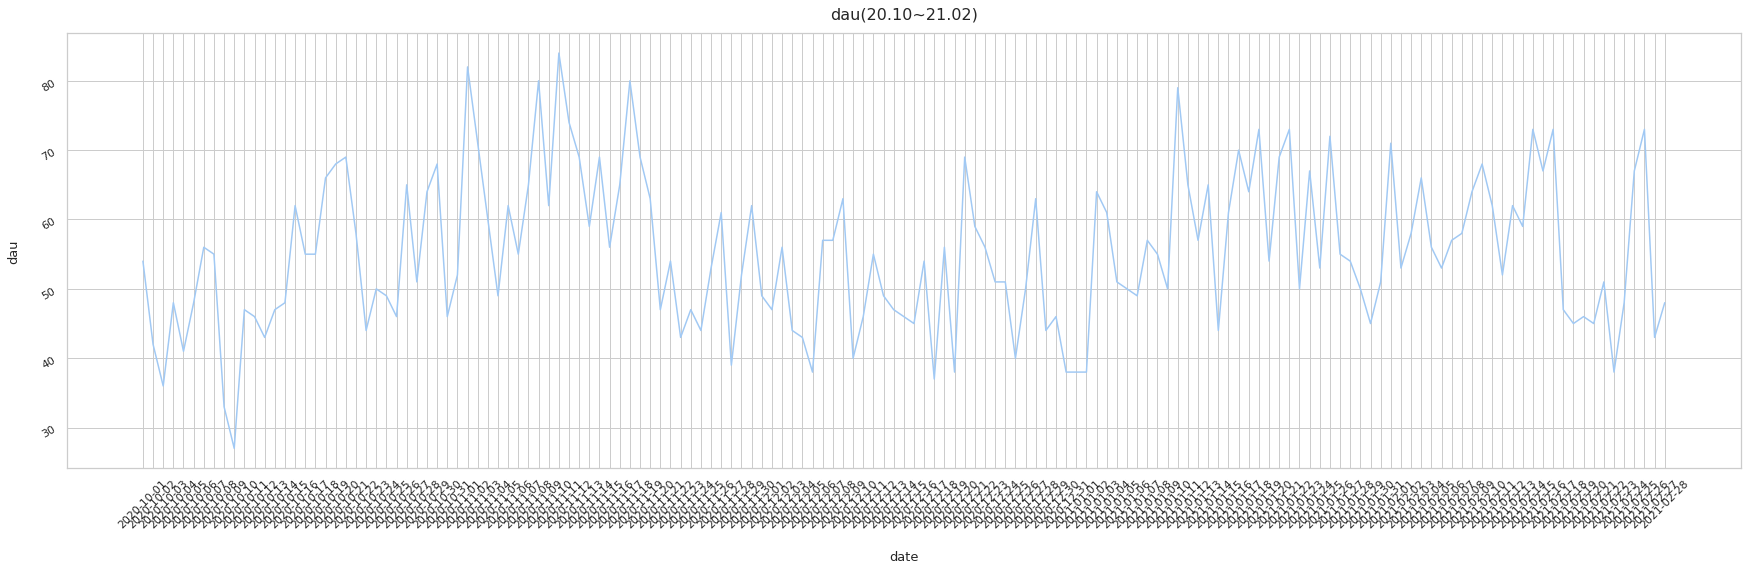

In [17]:
sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=45)
plt.yticks(rotation=30)

g = sns.lineplot(x='date_time',y='dau',data=DAU)
g.figure.set_size_inches(30,8)
# g.xaxis.set_major_locator(ticker.MultipleLocator(0))

g.set_title("dau(20.10~21.02)", pad = 15, size = 16)
g.set_xlabel("date",labelpad = 20, size = 13)
g.set_ylabel("dau",labelpad = 20, size = 13) 

Text(0, 0.5, 'mau')

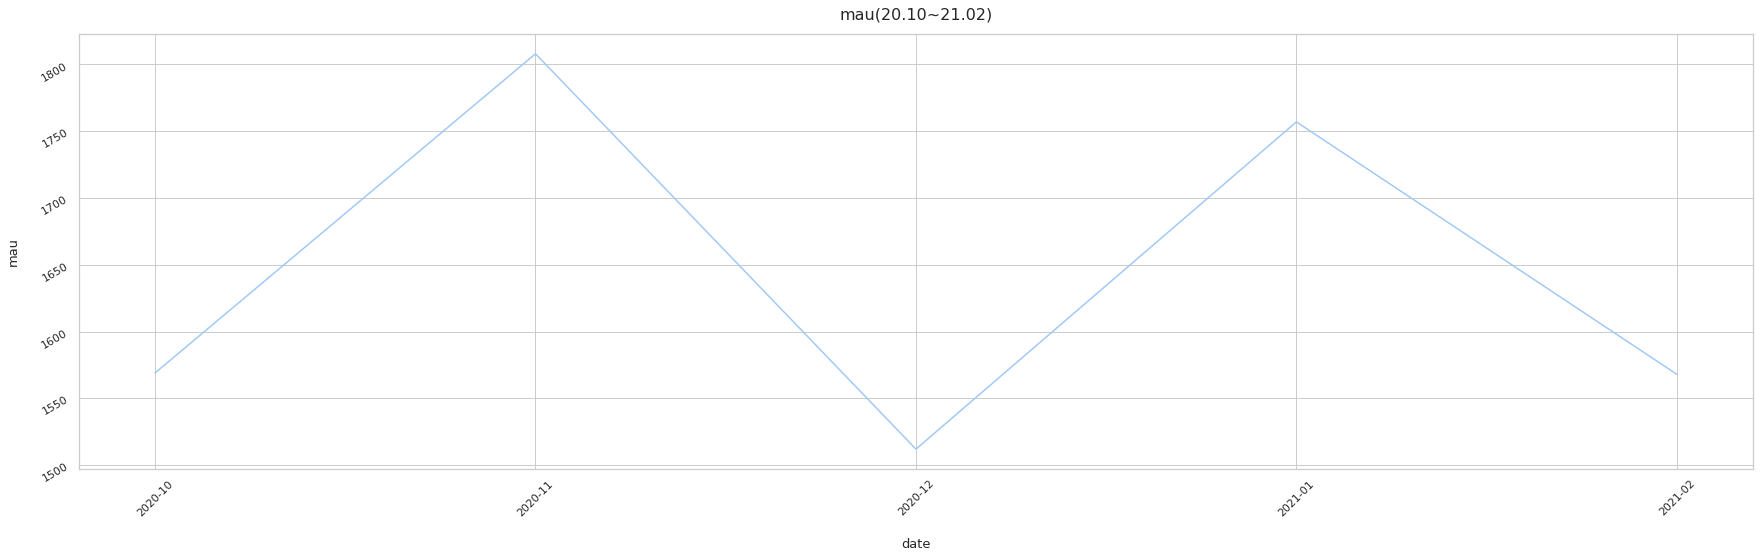

In [18]:
sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=45)
plt.yticks(rotation=30)

g = sns.lineplot(x='date_month',y='mau',data=MAU)
g.figure.set_size_inches(30,8)
# g.xaxis.set_major_locator(ticker.MultipleLocator(0))

g.set_title("mau(20.10~21.02)", pad = 15, size = 16)
g.set_xlabel("date",labelpad = 20, size = 13)
g.set_ylabel("mau",labelpad = 20, size = 13) 

Text(0, 0.5, 'stickiness')

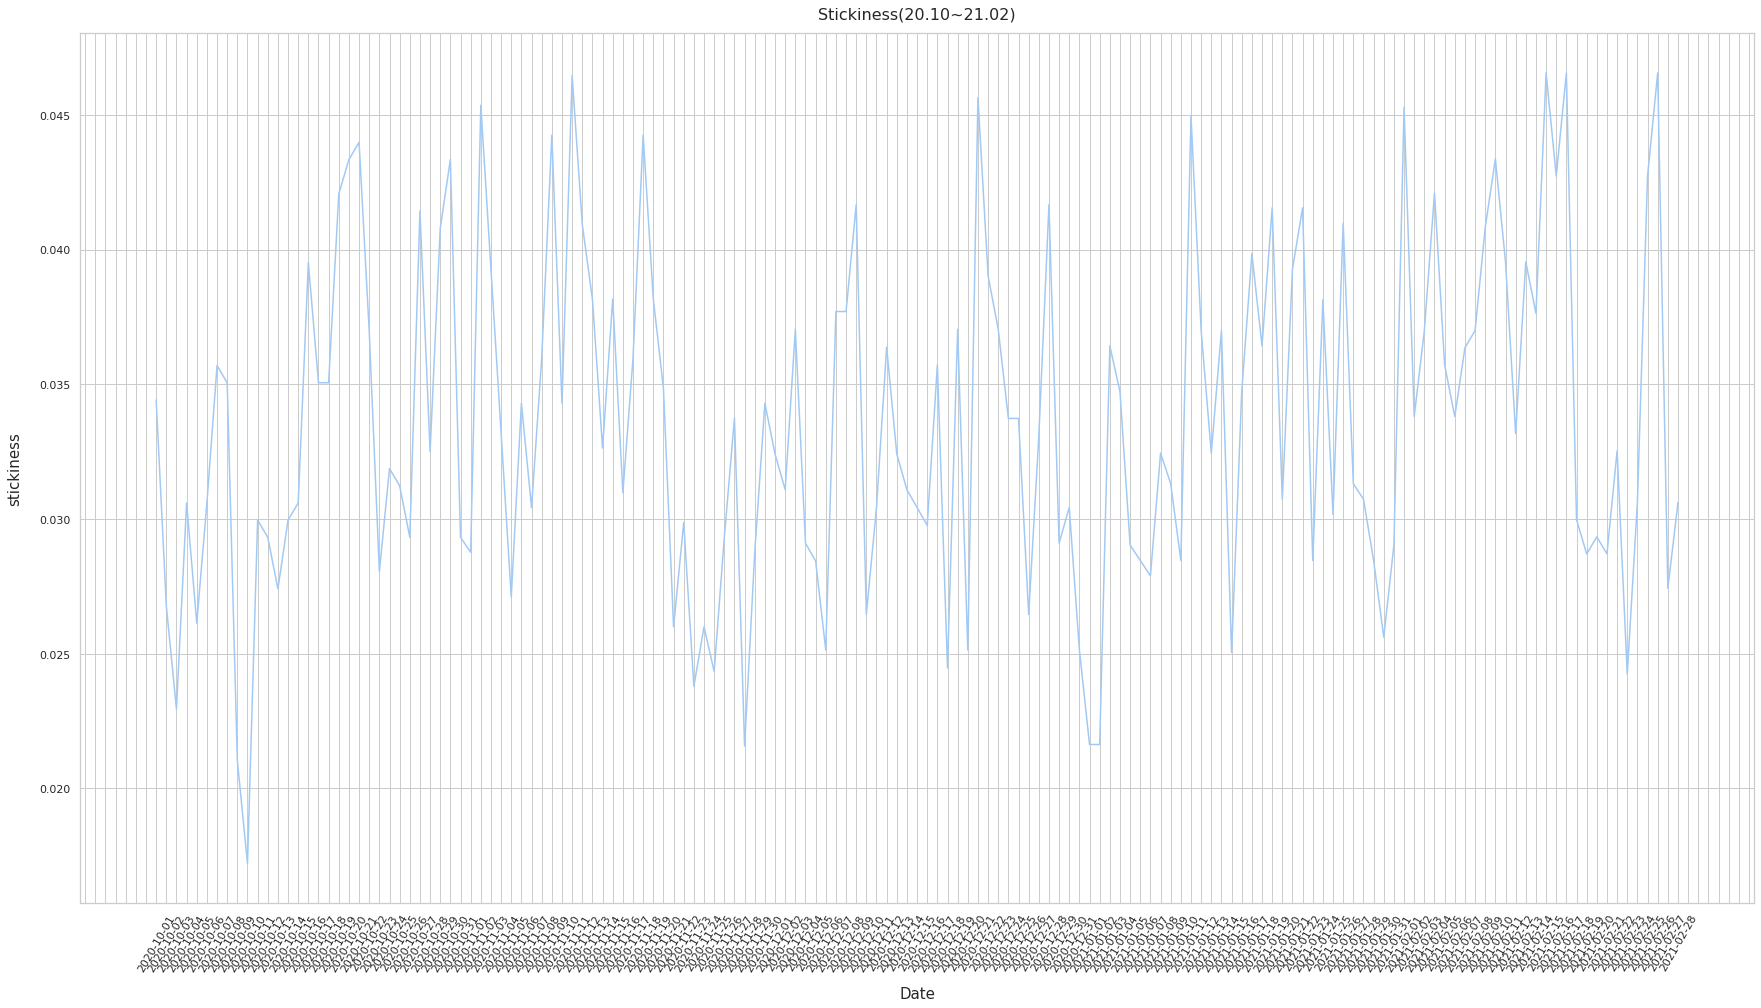

In [19]:
sns.set_theme(style = 'whitegrid', palette = 'pastel')
plt.xticks(rotation = 60)
plt.yticks(rotation = 0)

g = sns.lineplot(data = Stickiness, x='date_time', y = 'stickiness')
g.figure.set_size_inches(30,16)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))

g.set_title('Stickiness(20.10~21.02)', pad = 15, size = 16)
g.set_xlabel('Date',labelpad=13, size=15)
g.set_ylabel('stickiness',labelpad=17, size=15)


In [20]:
## 간단 해석
# 1. MAU를 기반으로 봤을때, 11월, 1월의 Active User 수가 많다.
# 2. Event별로 더 나눠서 체크해볼 필요가 있다.
# 3. 일단 이 project는 Data Handling 관련이므로, 분석 과정에 대해서는 Retailrocket E-commerce에서 대체한다.

## Cohort, RR
- 여기서는 간단하게, Month 기준으로 Cohort 분석을 하겠다.

In [115]:
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,date_time,date_month
0,2020-11-24 17:12:49+00:00,purchase,624700,2144415946687644409,appliances.kitchen.mixer,None,74.95,1515915625543288093,FzjIt916mJ,2020-11-24,2020-11
1,2021-01-07 10:03:49+00:00,view,19491,2144415923207929981,auto.accessories.player,pioneer,366.51,1515915625573811494,AFQYh0htbF,2021-01-07,2021-01
2,2021-02-23 10:36:57+00:00,view,1016042,2144415927125410016,None,hyundai,16.51,1515915625608728253,WO6YbQ4sIS,2021-02-23,2021-02
3,2020-10-07 17:29:26+00:00,view,3557825,2144415927049912542,electronics.video.tv,samsung,1120.68,1515915625523292226,4EsHwsQcUn,2020-10-07,2020-10
4,2020-10-12 07:35:35+00:00,view,1423328,2144415923107266682,computers.peripherals.printer,brother,199.37,1515915625516699565,NWicYKCWLo,2020-10-12,2020-10
...,...,...,...,...,...,...,...,...,...,...,...
8523,2021-02-13 19:46:59+00:00,cart,4079061,2144415922427789416,computers.components.videocards,powercolor,399.48,1515915625605175218,w8MDYHYeSQ,2021-02-13,2021-02
8524,2021-02-17 10:08:01+00:00,view,4101093,2176606883765289435,None,ajax,241.08,1515915625606457575,nTeMJ3jFcb,2021-02-17,2021-02
8525,2021-01-25 09:33:05+00:00,view,4170507,2144415929943982381,electronics.audio.microphone,maono,26.32,1515915625596907014,Xj3nbKpnUX,2021-01-25,2021-01
8526,2020-12-07 06:45:12+00:00,view,1745201,2144415926848585945,None,formula,107.16,1515915625551736770,7t4Zoi0LUe,2020-12-07,2020-12


In [116]:
def COHORT(df_in):
  df_cohort = df_in.copy()
  df_cohort = df_cohort[['event_time','date_month','date_time','user_id','user_session','event_type']].drop_duplicates()
  df_cohort = df_cohort.sort_values(by = 'event_time').reset_index(drop=True)

  df_first_visit = df_cohort[['date_month','user_id']].groupby('user_id')['date_month'].first().reset_index().rename(columns = {'date_month':'first_visit_month'})
  df_cohort = df_cohort.merge(df_first_visit,on='user_id')
  df_cohort['r30'] = ((pd.to_datetime(df_cohort['date_time'])- pd.to_datetime(df_cohort['first_visit_month']))/30).dt.days # -------★ datetime을 연산하고, timedelta인 형식을 int로 바꿔주는방법
  
  df_rr = df_cohort.groupby(['first_visit_month','r30'])['user_id'].count().unstack()  # -------★ unstack으로 data를 풀어주자.(r30이 column으로 이동)
  df_rr = df_rr.divide(df_rr[0],axis=0) 
  return df_cohort, df_rr

In [117]:
df_cohort, df_rr = COHORT(df)

In [122]:
df_cohort.groupby(['first_visit_month','r30'])['user_id'].count().unstack()

r30,0,1,2,3
first_visit_month,,,,
2020-10,1571.0,57.0,1.0,2.0
2020-11,1860.0,8.0,2.0,3.0
2020-12,1511.0,53.0,5.0,NaN
2021-01,1763.0,74.0,NaN,NaN
2021-02,1618.0,NaN,NaN,NaN


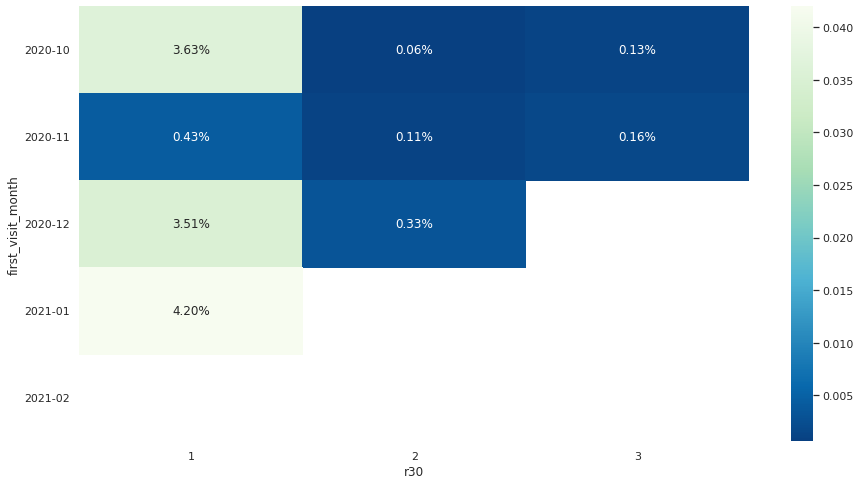

In [25]:
sns.set_theme(style = 'whitegrid', palette = 'GnBu_r')
g = sns.heatmap(data = df_cohort.iloc[:,1:], annot=True, fmt ='.2%', cmap='GnBu_r')
g.figure.set_size_inches(15, 8)

In [26]:
dbpath = "/content/drive/MyDrive/sql/user_log.db"
conn = sqlite3.connect(dbpath)
def SQL(query):
  cur = conn.cursor()
  cur.execute(query)
  df = pd.read_sql_query(query, conn)
  # return cur.fetchall()
  return df

In [128]:
query =\
'''
with t1 as(
select user_id, first_value(strftime('%Y-%m-%d', event_time)) over(partition by user_id order by event_time) as first_visit, strftime('%Y-%m-%d', event_time) as vday 
from user_data
where strftime('%Y-%m', event_time)>'2020-09'
order by vday)

, tt as (select strftime('%Y-%m', first_visit) as first_month,(strftime('%s',vday)-strftime('%s',first_visit))/60/60/24/30 as month_diff, count(user_id) as cnt from t1
group by first_month, month_diff
order by first_month)

select dm0.first_month
, dm0.cnt as '0M'
, dm1.cnt as '1M'
, dm2.cnt as '2M'
, dm3.cnt as '3M'

from (select * from tt where month_diff =0) dm0

left join (select * from tt where month_diff =1) dm1
on dm0.first_month = dm1.first_month

left join (select * from tt where month_diff =2) dm2
on dm0.first_month = dm2.first_month

left join (select * from tt where month_diff =3) dm3
on dm0.first_month = dm3.first_month


--left 
;'''
DF_COHORT = SQL(query)
DF_COHORT

,first_month,0M,1M,2M,3M
0,2020-10,1626,2.0,2.0,1.0
1,2020-11,1868,2.0,2.0,1.0
2,2020-12,1560,4.0,5.0,NaN
3,2021-01,1833,4.0,NaN,NaN
4,2021-02,1618,NaN,NaN,NaN
